In [15]:
import pandas as pd
#import italy covid cases
df_covid_iqa = pd.read_csv('covid_iqa.csv',delimiter=',', keep_default_na=False, na_values=[''])
df_covid_iqa['daily_cases'] = df_covid_iqa['daily_cases'].fillna(0)
df_covid_iqa.head()

,codice_provincia,codice_regione,daily_cases,data,denominazione_provincia,denominazione_regione,lat,lon,long,note,sigla_provincia,stato,totale_casi,IQA
0,37,8,0.0,2020-02-24,Bologna,Emilia-Romagna,44.494367,NaN,11.341721,NaN,BO,ITA,0,90.000000
1,37,8,0.0,2020-02-25,Bologna,Emilia-Romagna,44.494367,NaN,11.341721,NaN,BO,ITA,0,64.000000
2,37,8,0.0,2020-02-26,Bologna,Emilia-Romagna,44.494367,NaN,11.341721,NaN,BO,ITA,0,26.000000
3,37,8,0.0,2020-02-27,Bologna,Emilia-Romagna,44.494367,NaN,11.341721,NaN,BO,ITA,0,23.416667
4,37,8,0.0,2020-02-28,Bologna,Emilia-Romagna,44.494367,NaN,11.341721,NaN,BO,ITA,0,21.000000


In [16]:
# select city
df_covid_iqa = df_covid_iqa.loc[df_covid_iqa['denominazione_provincia'].isin(['Napoli'])]
df_covid_iqa[['data','daily_cases','totale_casi']].head()


,data,daily_cases,totale_casi
630,2020-02-24,0.0,0
631,2020-02-25,0.0,0
632,2020-02-26,0.0,0
633,2020-02-27,3.0,3
634,2020-02-28,1.0,4


In [18]:
# statistiche descrittive qualità aria
y= df_covid_iqa["IQA"]
stats = y.describe()
stats.loc['var'] = y.var()
stats.loc['skew'] = y.skew()
stats.loc['kurt'] = y.kurtosis()
print("statistiche descrittive qualita dell'aria")
print(stats)
# statistiche descrittive delta giornalieri

statistiche descrittive qualita dell'aria
count    160.000000
mean      47.188021
std       16.829314
min       20.000000
25%       34.000000
50%       44.000000
75%       56.000000
max      104.000000
var      283.225825
skew       1.157139
kurt       1.814236
Name: IQA, dtype: float64


Test normality for covid cases
Statistics = 87.494, p=0.000
Data looks non-Gaussian (reject null hypothesis)
Test normality for IQA
Statistics = 35.269, p=0.000
Data looks non-Gaussian (reject null hypothesis)


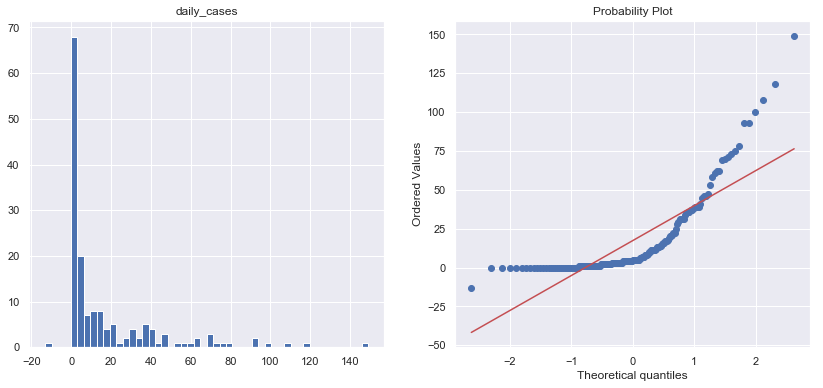

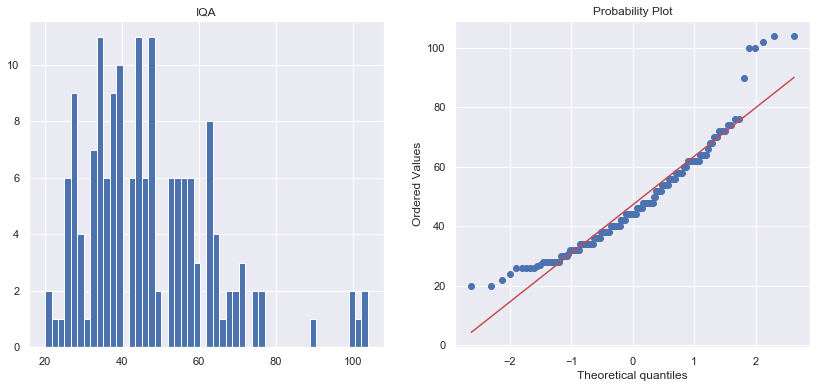

In [19]:
# Normal distribution test
import scipy
from scipy import stats
import matplotlib.pyplot as plt

print("Test normality for covid cases")
normality_test(df_covid_iqa['daily_cases'],"daily_cases")
print("Test normality for IQA")
normality_test(df_covid_iqa['IQA'],"IQA")
#box-cox transformation covid daily
#y_bc_covid = box_cox_transformation(df_covid_iqa['daily_cases'],"daily_cases")


In [5]:
def normality_test(data,target):
    stat,p = stats.normaltest(data)
    print("Statistics = %.3f, p=%.3f" % (stat,p))
    alpha = 0.05
    if p> alpha:
        print('Data looks Gaussian (fail to reject null hypothesis)')
    else:
        print('Data looks non-Gaussian (reject null hypothesis)')

    #test normalità 
    jarque_bera_test = stats.jarque_bera(data)
    jarque_bera_test

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    data.hist(bins=50)
    plt.title(target)
    plt.subplot(1,2,2)
    stats.probplot(data, plot=plt);
    data.describe().T

In [16]:
#box cox transformation
import pmdarima as pm
from pmdarima import preprocessing
def box_cox_transformation(data,target):
    y = data.values
    # Box Cox Transformation per renderla normale
    m_bce = preprocessing.BoxCoxEndogTransformer().fit(y)
    y_bc, _ = m_bce.transform(y)
    
#     plt.figure(figsize=(14,6))
#     plt.subplot(1,2,1)
#     data.hist(bins=50)
#     plt.title(target)
#     plt.subplot(1,2,2)
#     stats.probplot(data, plot=plt);
#     data.describe().T
    return y_bc

             daily_cases       IQA
daily_cases     1.000000  0.063349
IQA             0.063349  1.000000


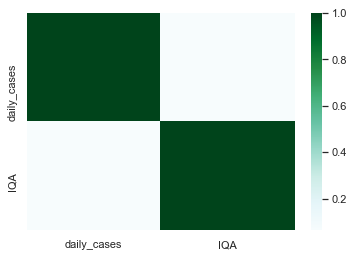

In [20]:
# Pearson correlation
import seaborn as sns; sns.set()
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# minmax scalar
scaler = MinMaxScaler()
df_covid_iqa['IQA_tr'] = scaler.fit_transform(df_covid_iqa[['IQA']])
df_covid_iqa['IQA_tr'] = 1- df_covid_iqa['IQA_tr'] 

# correlation matrix
corr = df_covid_iqa[["daily_cases","IQA"]].corr(method='pearson')
print(corr)
sns.heatmap(corr, cmap="BuGn")

In [61]:
# Let's transform the series
y_tr_cases = transform_function(df_covid_iqa['daily_cases'])
y_tr_iqa = transform_function(df_covid_iqa['IQA'])

In [30]:
import numpy as np
def transform_function(df):
    #df = df.apply(np.log).diff().dropna()
    df = df.diff().dropna()
    return df

In [62]:
print("stationarity test for cases")
kpss_test(y_tr_cases)
print("stationarity test for iqa")
kpss_test(y_tr_iqa)

stationarity test for cases
KPSS Statistic: 0.11915063252555987
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
stationarity test for iqa
KPSS Statistic: 0.28737629745342347
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\g.donatiello\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\g.donatiello\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\g.donatiello\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [34]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')


     daily_cases   IQA
160          0.0   2.0
161          2.0 -14.0
162          6.0 -56.0
163         -5.0   8.0
164         -2.0   4.0
(156, 2)
Y = daily_cases, X = daily_cases, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Y = IQA, X = daily_cases, P Values = [0.0029, 0.0108, 0.0045, 0.0019, 0.003, 0.0024, 0.0003, 0.0001]
Y = daily_cases, X = IQA, P Values = [0.8037, 0.8701, 0.1907, 0.2713, 0.16, 0.1665, 0.2767, 0.3295]
Y = IQA, X = IQA, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
               daily_cases_x  IQA_x
daily_cases_y         1.0000   0.16
IQA_y                 0.0001   1.00
(2, 2)


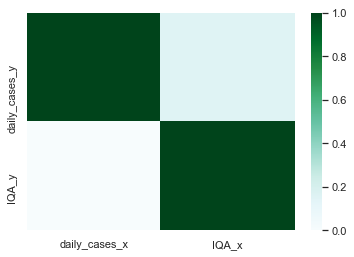

In [63]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
#granger causality test
columns=["daily_cases","IQA"]
dataset = pd.DataFrame(columns=columns)
dataset["daily_cases"] = y_tr_cases
dataset["IQA"] = y_tr_iqa
print(dataset.head())
print(dataset.shape)
data = grangers_causality_matrix(dataset, variables = dataset.columns,verbose=True)  
#data = 1 - data
print(data)
print(data.shape)
sns.heatmap(data, cmap="BuGn")

In [38]:
#granger causality test function
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', maxlag=8, verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]

    return dataset